In [1]:
import torch
from torch import nn
from torch.utils import data
import pandas as pd
from d2l import torch as d2l
import numpy as np

In [2]:
# Load the dataset
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

print(train_df.shape)
print(test_df.shape)

# Delete ID and labels
features = pd.concat((train_df.iloc[:,1:-1], test_df.iloc[:,1:]))
features.iloc[:4, [0, 1, 2, 3, -3, -2, -1]]

(1460, 81)
(1459, 80)


,MSSubClass,MSZoning,LotFrontage,LotArea,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,2008,WD,Normal
1,20,RL,80.0,9600,2007,WD,Normal
2,60,RL,68.0,11250,2008,WD,Normal
3,70,RL,60.0,9550,2006,WD,Abnorml


In [3]:
# Pre-processing
numeric_features = features.dtypes[features.dtypes != object].index
numeric_features

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')

In [4]:
# Numerical Columns
# Normalization
features[numeric_features] = features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std())
)

# Fill N/A value
features[numeric_features] = features[numeric_features].fillna(0)

# Categorical Columns
features = pd.get_dummies(features, dummy_na=True, dtype=int)
features.shape


(2919, 330)

In [5]:
n_train = train_df.shape[0]
train_features = torch.tensor(features[:n_train].values, dtype=torch.float32)
test_features = torch.tensor(features[n_train:].values, dtype=torch.float32)

train_labels = torch.tensor(train_df.iloc[:, -1].values.reshape(-1, 1), dtype = torch.float32)

In [59]:
# Define the network
num_input = train_features.shape[1]
num_hiddens1, num_hiddens2 = 32, 16

def get_net():
    net = nn.Sequential(
        nn.Linear(num_input, num_hiddens1),
        nn.ReLU(),
        nn.Linear(num_hiddens1, num_hiddens2),
        nn.ReLU(),
        nn.Linear(num_hiddens2, 1)
    )

    return net

In [7]:
# Define the loss

loss = nn.MSELoss()

def log_rmse(net, features, labels):
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds), torch.log(labels)))

    return rmse.item()

In [8]:
# Create Data Loader
def load_array(data_arrays, batch_size, is_train=True):
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

In [9]:
# Train for one epoch
def train_epoch(net, train_iter, loss, updater):
    if isinstance(net, torch.nn.Module):
        net.train()
    
    for X, y in train_iter:
        y_hat = net(X)
        l = loss(y_hat, y)

        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l = loss(net(X), y)
            l.backward()
            updater.step()

In [10]:
# Train model
def train(net, train_features, train_labels, test_features, test_labels, num_epochs, learning_rate, weight_decay, batch_size):
    train_iter = load_array((train_features, train_labels), batch_size)
    updater = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=weight_decay)
    train_ls, test_ls = [], []

    for epoch in range(num_epochs):
        train_epoch(net, train_iter, loss, updater)
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    
    return train_ls, test_ls

In [11]:
# K-fold data
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None

    for j in range(k):
        idx = slice(j * fold_size, (j+1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]

        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    
    return X_train, y_train, X_valid, y_valid

In [12]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay, batch_size):
    train_l_sum, valid_l_sum = 0,0

    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate, weight_decay, batch_size)
        
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]

        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'fold {i + 1}, train log rmse {float(train_ls[-1]):f}, '
              f'valid log rmse {float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

fold 1, train log rmse 0.128899, valid log rmse 0.149274
fold 2, train log rmse 0.124029, valid log rmse 0.148526
fold 3, train log rmse 0.128244, valid log rmse 0.143376
fold 4, train log rmse 0.130603, valid log rmse 0.137125
fold 5, train log rmse 0.115132, valid log rmse 0.163158
5-fold evaluation: Average trainning log rmse: 0.125382, Average validating log rmse: 0.148292


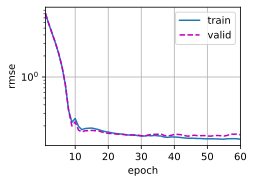

In [75]:
k, num_epochs, lr, weight_decay, batch_size = 5, 60, 0.03, 0.03, 128
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-fold evaluation: Average trainning log rmse: {float(train_l):f}, '
      f'Average validating log rmse: {float(valid_l):f}')

train log rmse 0.125534


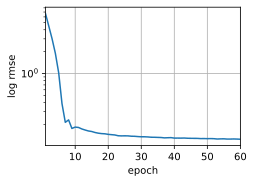

In [76]:
def train_and_pred(train_features, test_feature, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'train log rmse {float(train_ls[-1]):f}')
    preds = net(test_features).detach().numpy()
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)

train_and_pred(train_features, test_features, train_labels, test_df,
               num_epochs, lr, weight_decay, batch_size)